# TESR for TEST

In [1]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Quadro RTX 8000, 528.24, 46080 MiB


## First Stage SwinIR for Image Super-Resolution

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as f
from pytorch_lightning import Trainer
import tqdm as notebook_tqdm

import warnings
warnings.simplefilter('ignore')

import numpy as np
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from torchsummary import summary
from tqdm.notebook import tqdm
from functools import partial

In [3]:
# check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_path = "D:/Anas/PHD_Visting/Code/UCMerced_LandUse/Images/*/*.*"

### SwinIR_Network

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)
        
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops

In [6]:
class CharbonnierLoss(pl.LightningModule):#nn.Module
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss

In [7]:
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
def Rev_trans_LR(imgs):
    upscale = 2
    height = (imgs.shape[2]  * upscale)
    width = (imgs.shape[3]  * upscale )
    return transforms.Resize((height, width))(imgs)

class PL_Model(pl.LightningModule):
    def __init__(self,):
        super().__init__()
        # self.lossM = nn.MSELoss()#.cuda()
        self.lossM = CharbonnierLoss().to(device)
        self.upsampler = 'pixelshuffle'
        self.upscale = 2
        self.window_size = 8
        self.height = (128 // self.upscale )#192
        self.width = (128 // self.upscale )#192

        self.model_1  = SwinIR(upscale=self.upscale, in_chans=3,
                    img_size=(self.height, self.width),
                    window_size=self.window_size,#Must width and hight divisible by window_size
                    img_range=1.,
                    depths=[6, 6, 6, 6, 6, 6],
                    embed_dim=180,
                    num_heads=[6, 6, 6, 6, 6, 6],#, 6, 6
                    mlp_ratio=2,
                    upsampler = self.upsampler,
                    resi_connection='1conv')
        
        self.PATH = 'C:/Users/anasm/Lab_notebook/TESR/001_classicalSR_DF2K_s64w8_SwinIR-M_x2.pth'
        # self.PATH = 'C:/Users/anasm/Lab_notebook/TESR/weights_Swinir_Remote_Sensing/Swinir_Remote_Sensingx2_64.pth'
        param_key_g = 'params'
        self.pretrained_model = torch.load(self.PATH, map_location=device)
        self.model_1.load_state_dict(self.pretrained_model[param_key_g] if param_key_g in self.pretrained_model.keys() else self.pretrained_model, strict=True)
        # params = self.model_1.state_dict()
        # keys = list(params.keys())
        # param_not_freaze = keys[-16: 549]
        # for param in self.model_1.parameters():
        #     param.requires_grad = False
        # for name, param in self.model_1.named_parameters():
        #     for i in param_not_freaze:
        #         if name == i:
        #             param.requires_grad = True
        # for par in self.model_1.parameters():
        #     print(par)
        self.model_1.to(device)
        
        self.psnr = PeakSignalNoiseRatio()
        # self.ssim = StructuralSimilarityIndexMeasure()
        self.psnr_Train = []
        self.psnr_Test = []
        # self.ssim_Train = []
        # self.ssim_Test = []
        # self.psnr_Train = 0.0#[]
        # self.psnr_Test = 0.0#[]
        # self.ssim_Train = 0.0#[]
        # self.ssim_Test = 0.0#[]
        
    def forward(self, x):
        x_hat = self.model_1(x)
        # no activation and no softmax at the end
        return x_hat    

    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0002)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.2, 
                                                         patience=5, 
                                                         min_lr=5e-5)
        return {"optimizer": optimizer,
                "lr_scheduler": scheduler,
                "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        x = batch
        x_lr = trans_LR(x)
        x_hat = self.model_1(x_lr)
        loss = self.lossM(x_hat, x) 
        # Logging to TensorBoard by default
        
        psnr_t = self.psnr(x_hat, x).cpu().detach().numpy()
        self.psnr_Train.append(psnr_t.item())
        self.log('train_loss', loss)#, on_epoch = True
        return loss
    
    def training_epoch_end(self, batch):

        print("Number of train Image",len(self.psnr_Train))
        PSNR_Train = (sum(self.psnr_Train) / len(self.psnr_Train))
        # print("The Train average PSNR of ",PSNR_Train)
        print("The Train average PSNR is : ", end="")
        print("{0:.3f}".format(PSNR_Train))
        self.psnr_Train = []
        # self.ssim_Train = []
        print("#######################################################################")
        print("#######################################################################")


    def validation_step(self, batch, batch_idx):
        x = batch
        x_lr = trans_LR(x)
        x_hat = self.model_1(x_lr)
        # x_hat = self.model_2(x_lr) 
        loss = self.lossM(x_hat, x)    
        psnr_t = self.psnr(x_hat, x).cpu().detach().numpy()
        self.psnr_Test.append(psnr_t.item())
        # Logging to TensorBoard by default
        self.log('val_loss', loss)
        return loss
    
    def validation_epoch_end(self, batch):

        print("Number of test Image",len(self.psnr_Test))
        PSNR_TEST = sum(self.psnr_Test) / len(self.psnr_Test)
        # print("The Test average PSNR of {}".formate(PSNR_TEST))
        print("The Test average PSNR is : ", end="")
        print("{0:.3f}".format(PSNR_TEST))
        # self.log('Test average PSNR ', PSNR_TEST)
        self.psnr_Test = []

        
    
    def test_step(self, batch, batch_idx):
        x = batch
        x_lr = trans_LR(x)
        x_hat = self.model_1(x_lr)
        loss = self.lossM(x_hat, x) 
        # Logging to TensorBoard by default
        self.log('test_loss', loss)
        return loss
model = PL_Model()

### Load Training Weights

In [8]:
#Path of Weights
PATH = 'D:/Anas/final_UAV_Model_weights/weights_Swinir_Remote_Sensing/001_classicalSR_DF2K_s64w8_SwinIR-M_x2_v2.pth'
# torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH), strict=False)

<All keys matched successfully>

In [9]:
# model

### Visualization some Test Images

In [10]:

stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)#Norm  it into [-2, 2]

transform = transforms.Compose([transforms.Resize((128,128)), #64, 128
                                transforms.RandomRotation(degrees = 5),
                                transforms.RandomRotation(degrees = 10),
                                transforms.RandomRotation(degrees = 15),
                                transforms.ToTensor(), # This makes it into [0, 1]
                                # transforms.RandomErasing(p=0.1),
                                # transforms.Normalize(*stats)
                                transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
                                # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))# Norm  it into [-1, 1]
                                ]) 

transform_test = transforms.Compose([transforms.Resize((128,128)), #64, 128
                                transforms.ToTensor(), # This makes it into [0, 1]
                                # transforms.RandomErasing(p=0.1),
                                # transforms.Normalize(*stats)
                                transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
                                # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))# Norm  it into [-1, 1]
                                ]) 

In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
import glob
class PreDataset(Dataset):
    def __init__(self, Input_dir, transform):
        self.Input_dir = Input_dir
        # self.Traget_dir = Traget_dir
        self.transform = transform

        # self.all_imgs = os.listdir(main_dir)
        self.Input_imgs = glob.glob(Input_dir)
        # self.Traget_imgs = glob.glob(Traget_dir)

    def __len__(self):
        return len(self.Input_imgs)

    def __getitem__(self, idx):
        In_img_loc = os.path.join(self.Input_dir, self.Input_imgs[idx])
        # Tr_img_loc = os.path.join(self.Traget_dir, self.Traget_imgs[idx])

        In_image = Image.open(In_img_loc).convert("RGB")
        IN_tensor = self.transform(In_image)

        # Tr_image = Image.open(Tr_img_loc).convert("RGB")
        # Tr_tensor = self.transform(Tr_image)
        return IN_tensor

In [13]:
def trans_LR(imgs):
    upscale = 2
    height = (imgs.shape[2]  // upscale)
    width = (imgs.shape[3]  // upscale )
    return transforms.Resize((height, width))(imgs)

Runtime of 100 Test image is 5.2039954662323 sec
time of one image is 0.052039954662323 sec
The average PSNR of 100 images are 32.46527862548828 dB
The average SSIM of 100 images are 0.9621672034263611 


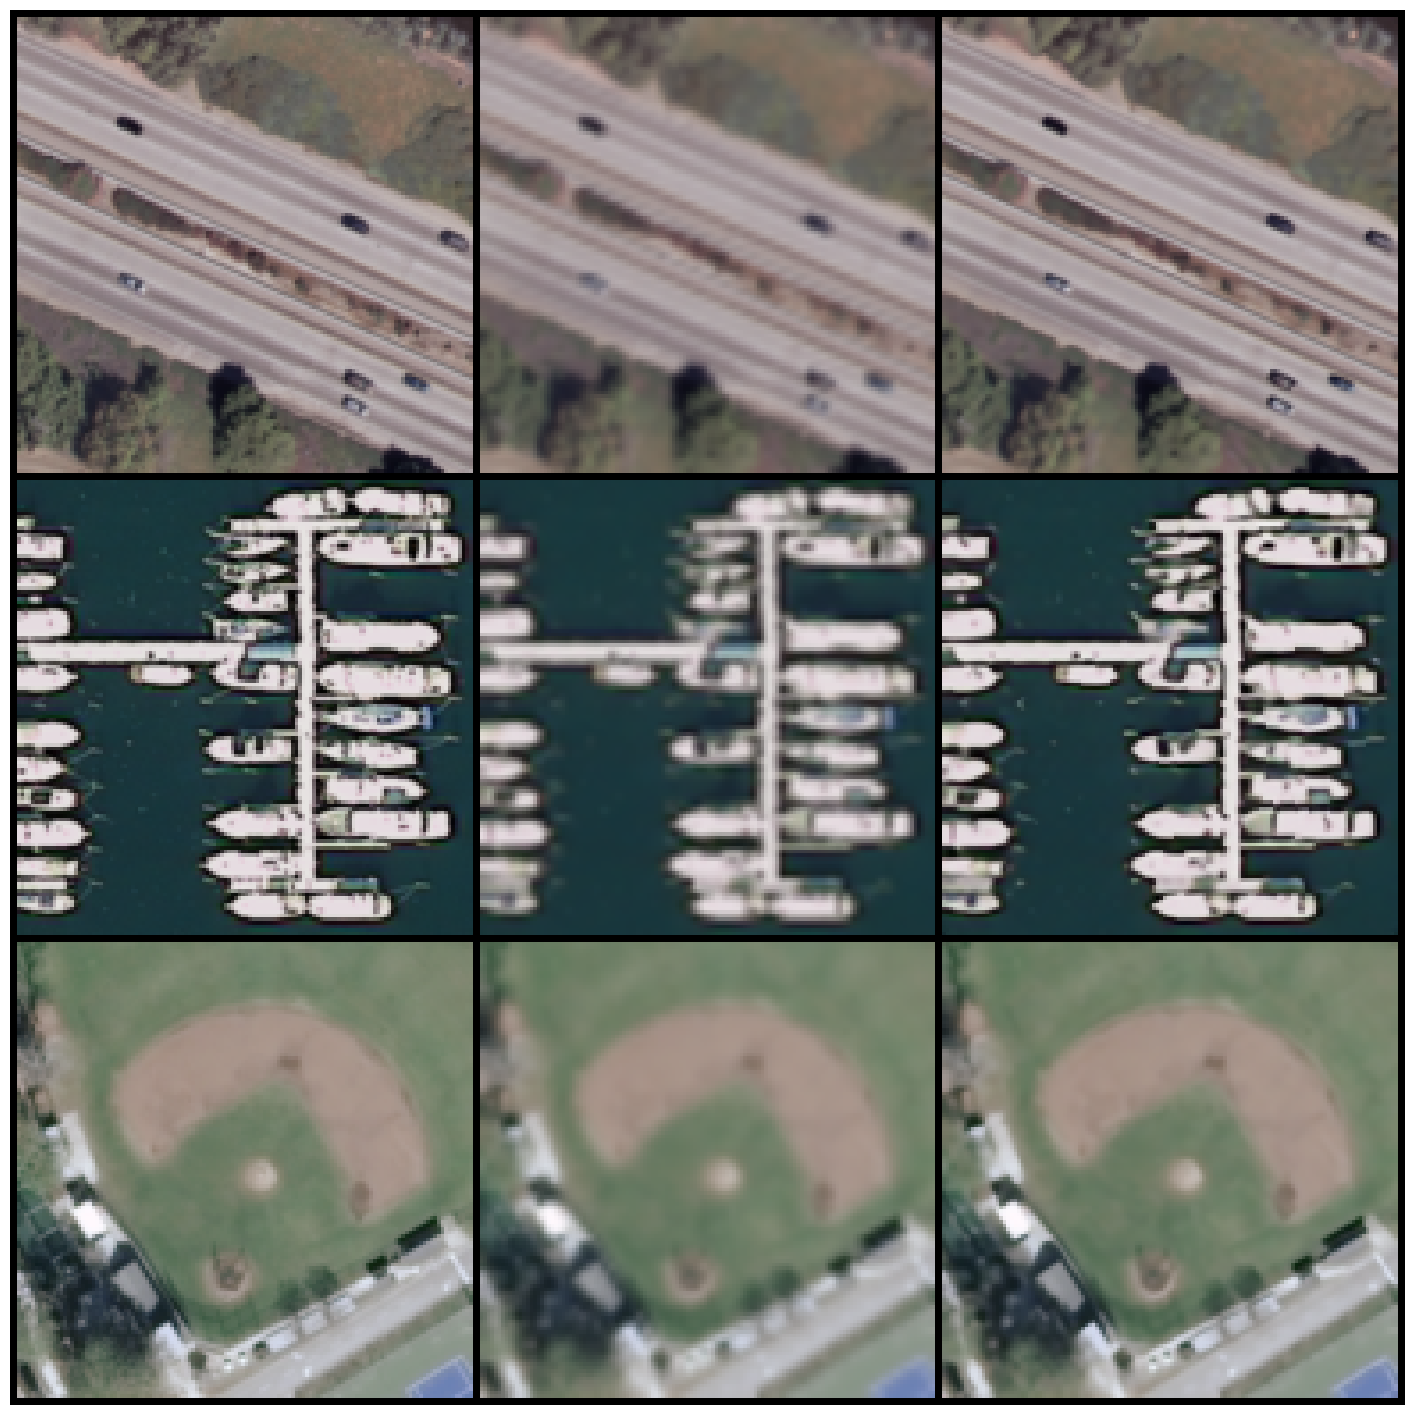

In [14]:
from torchmetrics import PeakSignalNoiseRatio       
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.functional import multiscale_structural_similarity_index_measure

ssim = StructuralSimilarityIndexMeasure()
psnr = PeakSignalNoiseRatio()

def Rev_trans_LR(imgs):
    upscale = 2
    height = (imgs.shape[2]  * upscale)
    width = (imgs.shape[3]  * upscale )
    return transforms.Resize((height, width))(imgs)

def visualize_reconstructions(model, input_imgs, num_test_img):
    # Reconstruct images
    input_imgs_ = trans_LR(input_imgs)
    start = time.time()
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs_.cuda().float())#.to(model)model.
    reconst_imgs = reconst_imgs.cpu()
    end = time.time()
    PSNR_test = psnr(reconst_imgs, input_imgs).numpy()
    print(f"Runtime of {num_test_img} Test image is {end - start} sec")
    print("time of one image is {} sec".format((end - start)/input_imgs.shape[0]))
    print("The average PSNR of {} images are {} dB".format(input_imgs.shape[0], PSNR_test))
    SSIM_test = ssim(reconst_imgs, input_imgs).numpy()
    print("The average SSIM of {} images are {} ".format(input_imgs.shape[0], SSIM_test ))
    # MS_SSIM_ =  multiscale_structural_similarity_index_measure(reconst_imgs, input_imgs).numpy()
    # print("The average MS-SSIM of {} images are {} ".format(input_imgs.shape[0], MS_SSIM_ ))
    # Plotting
    imgs = torch.stack([input_imgs, Rev_trans_LR(input_imgs_), reconst_imgs], dim=1).flatten(0, 1)#Rev_trans_LR(input_imgs_)
    grid = torchvision.utils.make_grid(imgs[0:9], nrow=3, normalize=True,value_range=(-1, 1))#range=(-1, 1)
    grid = grid.permute(1, 2, 0)
    
        # ax.imshow(make_grid(denorm(batch.detach()[:number_to_show]), nrow=8).permute(1, 2, 0))
    plt.figure(figsize=(18, 24))
    # plt.title("Reconstructed from %i latents" % (model.hparams.latent_dim))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()
    return PSNR_test, SSIM_test#reconst_imgs, input_imgs
# function to add some noise to images
import glob
import time
def calculate_Matrix():
    def get_train_images(num):
        return torch.stack([test_LP[i] for i in range(num)], dim=0)#[0]
    
    numbe_of_Images = glob.glob(data_path)
    test_LP= PreDataset(data_path, transform=transform_test)
    LP_train, test_LP = torch.utils.data.random_split(test_LP, [100, 2000])#520
    test_LP = LP_train
    # benchmark_test_LP = DataLoader(test_LP, batch_size=1)
    num_test_img = 100
    input_imgs = get_train_images(num_test_img)

    avg_PSNR, avg_ssim = visualize_reconstructions(model, input_imgs, num_test_img)
calculate_Matrix()

### Save Image to Next Stage

In [15]:
numbe_of_Images = glob.glob(data_path)
lenth_RS = len(numbe_of_Images)
pre_RS= PreDataset(data_path, transform=transform_test)
# LP_train, test_LP = torch.utils.data.random_split(test_LP, [2000, 100])#520
def get_train_images(num):
    return torch.stack([pre_RS[i] for i in range(num)], dim=0)#[0]
input_imgs = get_train_images(lenth_RS)

In [16]:
reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

In [17]:
from torchvision.utils import save_image
s = 0#2000
e = 100#2100
model = model.cuda()
import time
start = time.time()
images = input_imgs[s:e]
input_imgs_ = trans_LR(images)
print(input_imgs_.shape)
with torch.no_grad():
    reconst_imgs = model(input_imgs_.to(device))#.to(device)
    reconst_imgs = reconst_imgs.cpu()#.permute(1, 2, 0)
print(reconst_imgs.shape)
n = 0
for k in reconst_imgs:
    rev_k = reverse_transforms(k)
    #Put your Path for Output First Stage
    path = 'D:/Anas/final_UAV_Model_weights/TEST_Only/agricultural{0:02d}.png'.format(n)
    rev_k.save(path)
    # save_image(k, 'D:/Anas/final_UAV_Model_weights/TEST_Only/agricultural{00}.png'.format(n))
    n+=1

torch.Size([100, 3, 64, 64])
torch.Size([100, 3, 128, 128])


# Second Diffusion Model for Enhancement

In [7]:
import warnings
warnings.simplefilter('ignore')

In [1]:
!git clone https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement.git

Cloning into 'Image-Super-Resolution-via-Iterative-Refinement'...


In [3]:
#You must go to this Path "Image-Super-Resolution-via-Iterative-Refinement/data/prepare_data.py" Then change the line 17 to line 33 with blow code

# def resize_and_convert_lr(img, size, resample):
#     # if(img.size[0] != size):
#     img = trans_fn.resize(img, (128, 128), resample)
#     # img = trans_fn.center_crop(img, (128, 128))
#     return img

# def resize_and_convert_hr(img, size, resample):
#     # if(img.size[0] != size):
#     img = trans_fn.resize(img, (128, 128), resample)
#     # img = trans_fn.center_crop(img, (128, 128))
#     return img

# def image_convert_bytes(img):
#     buffer = BytesIO()
#     img.save(buffer, format='png')
#     return buffer.getvalue()


# def resize_multiple(img, sizes=(16, 128), resample=Image.BICUBIC, lmdb_save=False):
#     lr_img = resize_and_convert_lr(img, sizes[0], resample)
#     hr_img = resize_and_convert_hr(img, sizes[1], resample)
#     sr_img = resize_and_convert_hr(lr_img, sizes[1], resample)


In [8]:
#Prepare Original Dataset to Be three folder [LR, HR, SR]
#Path for Prepare code
#Path for original dataset
#Path for New data

!python Image-Super-Resolution-via-Iterative-Refinement/data/prepare_data.py \
  --path D:/Anas/PHD_Visting/Code/UCMerced_LandUse/Images/agricultural \
    --out Image-Super-Resolution-via-Iterative-Refinement/out_swinir_X2 --size 16,128


0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
0/100 images processed 
16/100 images processed 
39/100 images processed 
63/100 images processed 
84/100 images processed 
95/100 images processed 
100/100 images processed 


C:\Users\anasm\Lab_notebook\TESR\Github_Test\Image-Super-Resolution-via-Iterative-Refinement\data\prepare_data.py:35: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def resize_multiple(img, sizes=(16, 128), resample=Image.BICUBIC, lmdb_save=False):
C:\Users\anasm\Lab_notebook\TESR\Github_Test\Image-Super-Resolution-via-Iterative-Refinement\data\prepare_data.py:105: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def prepare(img_path, out_path, n_worker, sizes=(16, 128), resample=Image.BICUBIC, lmdb_save=False):
C:\Users\anasm\Lab_notebook\TESR\Github_Test\Image-Super-Resolution-via-Iterative-Refinement\data\prepare_data.py:181: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resample_map = {'bilinear': Image.BILINEAR, 'bicubic': Image.BICUBIC}
C:\Users\anasm\Lab

In [21]:
# Copy an Replace all image from this path"D:/Anas/final_UAV_Model_weights/TEST_Only/" 
# to this path "Image-Super-Resolution-via-Iterative-Refinement/out_swinir_X2_16_128/lr_16/"


In [22]:
# Copy an Replace all image from this path"D:/Anas/final_UAV_Model_weights/TEST_Only/" 
# to this path "Image-Super-Resolution-via-Iterative-Refinement/out_swinir_X2_16_128/sr_16_128/"

### Configration File

In [25]:
# copy all the conf in below to "Image-Super-Resolution-via-Iterative-Refinement/config/sr_sr3_16_128.json" whith change the path of data and weights
# {
#     "name": "DM_Enhancement",
#     "phase": "train", // train or val
#     "gpu_ids": [
#         0
#     ],
#     "path": { //set the path
#         "log": "logs",
#         "tb_logger": "tb_logger",
#         "results": "results",
#         "checkpoint": "checkpoint",
#         "resume_state": "D:/Anas/final_UAV_Model_weights/TESR_Result/experiments/X2_Train/checkpoint/I670000_E1237"//null path of weights of Diffusion model
        
#         // "resume_state": "experiments/sr_ffhq_210806_204158/checkpoint/I640000_E37" //pretrain model or training state
#     },
#     "datasets": {
#         "train": {
#             "name": "DM_Enhancement",
#             "mode": "HR", // whether need LR img
#             "dataroot": "Image-Super-Resolution-via-Iterative-Refinement/out_swinir_X2",
#             "datatype": "img", //lmdb or img, path of img files
#             "l_resolution": 16, // low resolution need to super_resolution
#             "r_resolution": 128, // high resolution
#             "batch_size": 4,
#             "num_workers": 2,
#             "use_shuffle": true,
#             "data_len": -1 // -1 represents all data used in train
#         },
#         "val": {
#             "name": "DM_Enhancement",
#             "mode": "LRHR",
#             "dataroot": "Image-Super-Resolution-via-Iterative-Refinement/out_swinir_X2",
#             "datatype": "img", //lmdb or img, path of img files
#             "l_resolution": 16,
#             "r_resolution": 128,
#             "data_len": 100 //  data TEST 
#         }
#     },
#     "model": {
#         "which_model_G": "sr3", // use the ddpm or sr3 network structure
#         "finetune_norm": false,
#         "unet": {
#             "in_channel": 6,
#             "out_channel": 3,
#             "inner_channel": 64,
#             "channel_multiplier": [
#                 1,
#                 2,
#                 4,
#                 8,
#                 8
#             ],
#             "attn_res": [
#                 16
#             ],
#             "res_blocks": 2,
#             "dropout": 0.2
#         },
#         "beta_schedule": { // use munual beta_schedule for acceleration
#             "train": {
#                 "schedule": "linear",
#                 "n_timestep": 2000,
#                 "linear_start": 1e-6,
#                 "linear_end": 1e-2
#             },
#             "val": {
#                 "schedule": "linear",
#                 "n_timestep": 2000,
#                 "linear_start": 1e-6,
#                 "linear_end": 1e-2
#             }
#         },
#         "diffusion": {
#             "image_size": 128,
#             "channels": 3, //sample channel
#             "conditional": true // unconditional generation or unconditional generation(super_resolution)
#         }
#     },
#     "train": {
#         "n_iter": 660000,
#         "val_freq": 5000,
#         "save_checkpoint_freq": 5000,
#         "print_freq": 200,
#         "optimizer": {
#             "type": "adam",
#             "lr": 1e-4
#         },
#         "ema_scheduler": { // not used now
#             "step_start_ema": 5000,
#             "update_ema_every": 1,
#             "ema_decay": 0.9999
#         }
#     },
#     "wandb": {
#         "project": "DM_Enhancement"
#     }
# }

In [26]:
#Copy this class to "Image-Super-Resolution-via-Iterative-Refinement/model/sr3_modules/diffusion.py" in line 9
class CharbonnierLoss(nn.Module):#nn.Module
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss

In [27]:
# Add the blow code to line 100
        # elif self.loss_type == 'char':
        #     self.loss_func = CharbonnierLoss().to(device)

In [ ]:
# Change the l1 to char
        # loss_type='l1',  --->         loss_type='char',  
# in line 106

In [30]:
!python Image-Super-Resolution-via-Iterative-Refinement/sr.py\
-p val -c Image-Super-Resolution-via-Iterative-Refinement/config/sr_sr3_16_128.json

23-02-09 13:08:50.215 - INFO:   name: DM_Enhancement
  phase: val
  gpu_ids: [0]
  path:[
    log: experiments\DM_Enhancement_230209_130850\logs
    tb_logger: experiments\DM_Enhancement_230209_130850\tb_logger
    results: experiments\DM_Enhancement_230209_130850\results
    checkpoint: experiments\DM_Enhancement_230209_130850\checkpoint
    resume_state: D:/Anas/final_UAV_Model_weights/TESR_Result/experiments/X2_Train/checkpoint/I670000_E1237
    experiments_root: experiments\DM_Enhancement_230209_130850
  ]
  datasets:[
    train:[
      name: DM_Enhancement
      mode: HR
      dataroot: Image-Super-Resolution-via-Iterative-Refinement/out_swinir_X2_16_128
      datatype: img
      l_resolution: 16
      r_resolution: 128
      batch_size: 4
      num_workers: 2
      use_shuffle: True
      data_len: -1
    ]
    val:[
      name: DM_Enhancement
      mode: LRHR
      dataroot: Image-Super-Resolution-via-Iterative-Refinement/out_swinir_X2_16_128
      datatype: img
      l_resoluti

export CUDA_VISIBLE_DEVICES=0


sampling loop time step: 100%|##########| 2000/2000 [00:43<00:00, 46.02it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:41<00:00, 48.57it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:41<00:00, 47.82it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:39<00:00, 50.02it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:40<00:00, 49.29it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:40<00:00, 49.38it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:40<00:00, 49.53it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:39<00:00, 50.32it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:39<00:00, 50.10it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:39<00:00, 50.18it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:39<00:00, 50.20it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:40<00:00, 49.70it/s]

sampling loop time step: 100%|##########| 2000/2000 [00:40<00:00

In [31]:
from torchvision import datasets, transforms
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
transform_test = transforms.Compose([
                                transforms.Resize((256,256)), #64, 128
                                transforms.ToTensor(), # This makes it into [0, 1]
                                ])

In [32]:
import glob
import torch
import os

from torch.utils.data import Dataset, DataLoader
class PreDataset(Dataset):
    def __init__(self, Input_dir, transform):
        self.Input_dir = Input_dir
        # self.Traget_dir = Traget_dir
        self.transform = transform

        # self.all_imgs = os.listdir(main_dir)
        self.Input_imgs = sorted(glob.glob(Input_dir))
        # self.Traget_imgs = glob.glob(Traget_dir)

    def __len__(self):
        return len(self.Input_imgs)

    def __getitem__(self, idx):
        In_img_loc = os.path.join(self.Input_dir, self.Input_imgs[idx])
        # Tr_img_loc = os.path.join(self.Traget_dir, self.Traget_imgs[idx])

        In_image = Image.open(In_img_loc).convert("RGB")
        IN_tensor = self.transform(In_image)

        # Tr_image = Image.open(Tr_img_loc).convert("RGB")
        # Tr_tensor = self.transform(Tr_image)
        return IN_tensor

In [35]:
SR_imgs= PreDataset('C:/Users/anasm/Lab_notebook/TESR/Github_Test/experiments/DM_Enhancement_230209_130850/results/*_sr.*', transform=transform_test)#X4_Test_1
HR_imgs= PreDataset('C:/Users/anasm/Lab_notebook/TESR/Github_Test/experiments/DM_Enhancement_230209_130850/results/*_hr.*', transform=transform_test)
LR_imgs= PreDataset('C:/Users/anasm/Lab_notebook/TESR/Github_Test/experiments/DM_Enhancement_230209_130850/results/*_lr.*', transform=transform_test)

In [36]:
from PIL import Image
n_img = 100
def get_SR_imgs(num):
    return torch.stack([SR_imgs[i] for i in range(num)], dim=0)#[0]
input_SR_imgs = get_SR_imgs(n_img)

def get_hr_imgs(num):
    return torch.stack([HR_imgs[i] for i in range(num)], dim=0)#[0]
input_HR_imgs= get_hr_imgs(n_img)

def get_lr_imgs(num):
    return torch.stack([LR_imgs[i] for i in range(num)], dim=0)#[0]
input_lr_imgs= get_lr_imgs(n_img)

In [41]:
from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.functional import multiscale_structural_similarity_index_measure
# MS_SSIM = multiscale_structural_similarity_index_measure()
ssim = StructuralSimilarityIndexMeasure()
psnr = PeakSignalNoiseRatio()

psnr_ = psnr(input_SR_imgs, input_HR_imgs)
ssim_ = ssim(input_SR_imgs, input_HR_imgs)
MS_SSIM_ =  multiscale_structural_similarity_index_measure(input_SR_imgs, input_HR_imgs)
print("PSNR    :",psnr_.numpy())
print("SSIM    :",ssim_.numpy())
print("MS-SSIM :",MS_SSIM_.numpy())

PSNR    : 37.01431
SSIM    : 0.9430163
MS-SSIM : 0.9801104


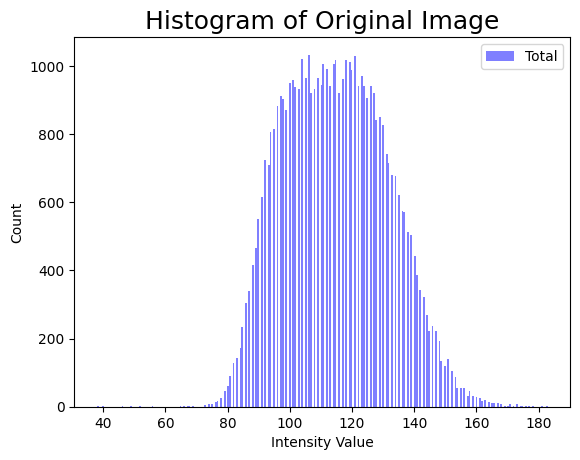

In [38]:
from skimage import io
import matplotlib.pyplot as plt
image = io.imread('C:/Users/anasm/Lab_notebook/TESR/Github_Test/experiments/DM_Enhancement_230209_130850/results/0_21_hr.png')
_ = plt.hist(image[:, :, :].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total',])#, 'Red_Channel', 'Green_Channel', 'Blue_Channel'
_ = plt.title('Histogram of Original Image', fontsize = 18)
plt.show()

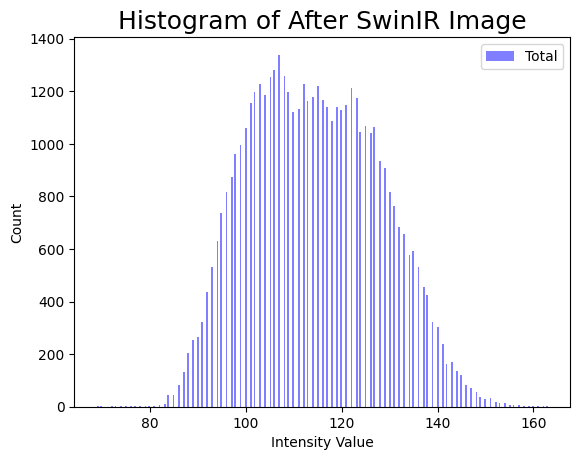

In [39]:
from skimage import io
import matplotlib.pyplot as plt
image = io.imread('C:/Users/anasm/Lab_notebook/TESR/Github_Test/experiments/DM_Enhancement_230209_130850/results/0_21_lr.png')
_ = plt.hist(image[:, :, :].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total',])#, 'Red_Channel', 'Green_Channel', 'Blue_Channel'
_ = plt.title('Histogram of After SwinIR Image', fontsize = 18)
plt.show()

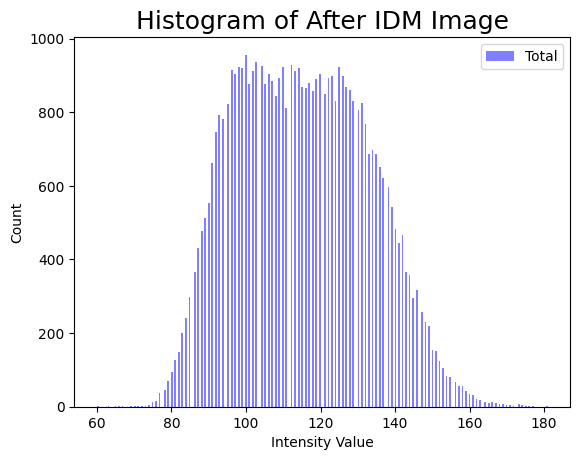

In [40]:
from skimage import io
import matplotlib.pyplot as plt
image = io.imread('C:/Users/anasm/Lab_notebook/TESR/Github_Test/experiments/DM_Enhancement_230209_130850/results/0_21_sr.png')
_ = plt.hist(image[:, :, :].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total',])#, 'Red_Channel', 'Green_Channel', 'Blue_Channel'
_ = plt.title('Histogram of After IDM Image', fontsize = 18)
plt.show()